# Versión con Ajuste Fino (Fine-Tuning) para el modelo multi-salida

Esta versión del código implementa el ajuste fino descongelando las últimas capas del modelo base EfficientNetB0 para mejorar la adaptación a tu conjunto de datos.

!pip install tensorflow

In [2]:
# Importar librerías necesarias
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 30
EPOCHS_FINE_TUNE = 30
LEARNING_RATE_INITIAL = 5e-5
LEARNING_RATE_FINE_TUNE = 5e-6
BASE_MODEL = 'EfficientNetB0'
USE_FOCAL_LOSS = True

In [4]:
# =============================================
# DICCIONARIOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

In [5]:
# Data loading and preparation functions
def load_and_prepare_data(csv_path):
    df = pd.read_csv(csv_path, sep='|')
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    return df

In [6]:
# Custom data generator with balanced sampling
class BalancedMultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias,
                 batch_size=32, img_size=(224,224), shuffle=True, augmentation=None):
        self.df = df
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        self.balance_data()

    def balance_data(self):
        y_partes = self.mlb_partes.transform(self.df['partes'])
        y_dannos = self.mlb_dannos.transform(self.df['dannos'])
        y_sugerencias = self.mlb_sugerencias.transform(self.df['sugerencias'])
        y_concat = np.hstack([y_partes, y_dannos, y_sugerencias])
        label_freq = np.sum(y_concat, axis=0)
        label_freq[label_freq == 0] = 1
        sample_weights = np.sum(y_concat / label_freq, axis=1)
        sample_weights = sample_weights / np.sum(sample_weights)
        n_samples = len(self.df)
        indices_resampled = np.random.choice(np.arange(len(self.df)), size=n_samples, replace=True, p=sample_weights)
        self.df = self.df.iloc[indices_resampled].reset_index(drop=True)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        X = np.empty((len(batch_df), *self.img_size, 3), dtype=np.float32)
        y_partes, y_dannos, y_sugerencias = [], [], []
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
            img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            y_partes.append(row['partes'])
            y_dannos.append(row['dannos'])
            y_sugerencias.append(row['sugerencias'])
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [7]:
# Swish activation
def swish(x):
    return x * tf.keras.backend.sigmoid(x)

In [8]:
# DropConnect layer simplified for compatibility
class DropConnect(layers.Layer):
    def __init__(self, drop_prob=0.5, **kwargs):
        super(DropConnect, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, inputs, training=None):
        if not training:
            return inputs
        keep_prob = 1.0 - self.drop_prob
        noise_shape = tf.shape(inputs)
        if len(inputs.shape) == 2:
            noise_shape = [tf.shape(inputs)[0], 1]
        else:
            noise_shape = tf.shape(inputs)
        return tf.nn.dropout(inputs, rate=self.drop_prob, noise_shape=noise_shape) / keep_prob

In [9]:
# Focal loss function
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return focal_loss_fixed

In [10]:
# Build improved multi-output model with more fine-tuning layers
def build_improved_model(input_shape, num_partes, num_dannos, num_sugerencias, base_model_name='EfficientNetB0', use_focal_loss=False):
    if base_model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")

    base_model.trainable = True
    # Unfreeze last 50 layers for fine-tuning
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = DropConnect(drop_prob=0.3)(x)
    x = layers.Dense(512, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    output_partes = layers.Dense(num_partes, activation='sigmoid', name='partes', kernel_regularizer=regularizers.l2(1e-4))(x)
    output_dannos = layers.Dense(num_dannos, activation='sigmoid', name='dannos')(x)
    output_sugerencias = layers.Dense(num_sugerencias, activation='sigmoid', name='sugerencias')(x)

    model = models.Model(inputs=inputs, outputs=[output_partes, output_dannos, output_sugerencias])

    losses = {
        'partes': focal_loss() if use_focal_loss else 'binary_crossentropy',
        'dannos': focal_loss() if use_focal_loss else 'binary_crossentropy',
        'sugerencias': focal_loss() if use_focal_loss else 'binary_crossentropy'
    }

    metrics = {
        'partes': ['accuracy'],
        'dannos': ['accuracy'],
        'sugerencias': ['accuracy']
    }

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_INITIAL), loss=losses, metrics=metrics)

    return model

In [11]:
# Threshold optimization per class
def optimize_thresholds(y_true, y_pred_probs, thresholds=np.arange(0.1, 0.9, 0.05)):
    best_thresholds = []
    for i in range(y_true.shape[1]):
        best_f1 = 0
        best_thresh = 0.5
        for thresh in thresholds:
            y_pred = (y_pred_probs[:, i] > thresh).astype(int)
            f1 = f1_score(y_true[:, i], y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        best_thresholds.append(best_thresh)
    return np.array(best_thresholds)

In [17]:
# Main training function
def main():
    IMG_DIR = '../data/fotos_siniestros/'
    train_df = load_and_prepare_data(os.path.join('data/fotos_siniestros/train/', 'train_set.csv'))
    val_df = load_and_prepare_data(os.path.join('data/fotos_siniestros/val/', 'val_set.csv'))

    mlb_partes = MultiLabelBinarizer()
    mlb_dannos = MultiLabelBinarizer()
    mlb_sugerencias = MultiLabelBinarizer()

    mlb_partes.fit(train_df['partes'])
    mlb_dannos.fit(train_df['dannos'])
    mlb_sugerencias.fit(train_df['sugerencias'])

    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = BalancedMultiLabelDataGenerator(
        train_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias,
        batch_size=BATCH_SIZE, img_size=IMG_SIZE, augmentation=train_datagen
    )

    val_generator = BalancedMultiLabelDataGenerator(
        val_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias,
        batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
    )

    model = build_improved_model(
        input_shape=(*IMG_SIZE, 3),
        num_partes=len(mlb_partes.classes_),
        num_dannos=len(mlb_dannos.classes_),
        num_sugerencias=len(mlb_sugerencias.classes_),
        base_model_name=BASE_MODEL,
        use_focal_loss=USE_FOCAL_LOSS
    )

    checkpoint = ModelCheckpoint(
        'best_model_improved.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    )

    history_initial = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS_INITIAL,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    # Optimize thresholds per class using validation data
    val_preds = model.predict(val_generator)
    thresholds_partes = optimize_thresholds(mlb_partes.transform(val_df['partes']), val_preds[0])
    thresholds_dannos = optimize_thresholds(mlb_dannos.transform(val_df['dannos']), val_preds[1])
    thresholds_sugerencias = optimize_thresholds(mlb_sugerencias.transform(val_df['sugerencias']), val_preds[2])

    print("Optimized thresholds:")
    print("Partes:", thresholds_partes)
    print("Dannos:", thresholds_dannos)
    print("Sugerencias:", thresholds_sugerencias)

    # Save thresholds for later use
    with open('optimized_thresholds.json', 'w') as f:
        json.dump({
            'partes': thresholds_partes.tolist(),
            'dannos': thresholds_dannos.tolist(),
            'sugerencias': thresholds_sugerencias.tolist()
        }, f)

    # Fine-tuning: unfreeze more layers and train with lower learning rate
    base_model = model.layers[1]
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
        loss={
            'partes': focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy',
            'dannos': focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy',
            'sugerencias': focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
        },
        metrics={
            'partes': ['accuracy'],
            'dannos': ['accuracy'],
            'sugerencias': ['accuracy']
        }
    )

    history_fine_tune = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS_FINE_TUNE,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    # Guardar modelo final
    model.save('final_model_fine_tuned_v3.keras')

if __name__ == "__main__":
    main()

/data/Python/DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetasTF_APIs_1500fotos/.venv-3-11/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.1708 - dannos_loss: 2.3986 - loss: 16.2635 - partes_accuracy: 0.0302 - partes_loss: 13.1594 - sugerencias_accuracy: 0.4835 - sugerencias_loss: 0.5373
Epoch 1: val_loss improved from inf to 4.98600, saving model to best_model_improved.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - dannos_accuracy: 0.1707 - dannos_loss: 2.3978 - loss: 16.2589 - partes_accuracy: 0.0304 - partes_loss: 13.1571 - sugerencias_accuracy: 0.4841 - sugerencias_loss: 0.5363 - val_dannos_accuracy: 0.1772 - val_dannos_loss: 0.7617 - val_loss: 4.9860 - val_partes_accuracy: 0.0157 - val_partes_loss: 3.9036 - val_sugerencias_accuracy: 0.5827 - val_sugerencias_loss: 0.1340 - learning_rate: 5.0000e-05
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dannos_accuracy: 0.1664 - dannos_loss: 2.2474 - loss: 15.3944 - partes_accuracy: 0.0415 - partes_loss: 12.4455 - sugerencias_accuracy: 0.5463 - sugerencias_loss: 0.4358
Epoch 2: val_loss did not improve from 4.98600
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - dannos_accuracy: 0.1666 - dannos_loss: 2.2452 - loss: 15.3879 - partes_accuracy: 0.0414 - partes_loss: 12.4402 - sugerencias_accuracy: 0.5461 - sugerencias_loss: 0.4360 - val_dannos_accuracy: 0.2008 - val_dannos_loss: 0.8414 - val_loss: 5.2330 - val_partes_

In [27]:
def evaluate_model_with_thresholds(model, generator, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds):
    results = model.evaluate(generator, verbose=1)
    print(f"Total loss: {results[0]}")
    print(f"Partes loss: {results[1]} - Partes accuracy: {results[4]}")
    print(f"Dannos loss: {results[2]} - Dannos accuracy: {results[5]}")
    print(f"Sugerencias loss: {results[3]} - Sugerencias accuracy: {results[6]}")

    predictions = model.predict(generator, verbose=1)

    y_true_partes = generator.mlb_partes.transform(generator.df['partes'])
    y_true_dannos = generator.mlb_dannos.transform(generator.df['dannos'])
    y_true_sugerencias = generator.mlb_sugerencias.transform(generator.df['sugerencias'])

    y_pred_partes = (predictions[0] > thresholds['partes']).astype(int)
    y_pred_dannos = (predictions[1] > thresholds['dannos']).astype(int)
    y_pred_sugerencias = (predictions[2] > thresholds['sugerencias']).astype(int)

    print("\nClassification Report for Partes:")
    print(classification_report(y_true_partes, y_pred_partes, zero_division=0))

    print("\nClassification Report for Dannos:")
    print(classification_report(y_true_dannos, y_pred_dannos, zero_division=0))

    print("\nClassification Report for Sugerencias:")
    print(classification_report(y_true_sugerencias, y_pred_sugerencias, zero_division=0))

if __name__ == "__main__":
    import sys
    import os
    import pickle

    if len(sys.argv) < 2:
        print("Usage: python evaluate_model.py <model_path>")
        sys.exit(1)

    model_path = sys.argv[1]

    @tf.keras.utils.register_keras_serializable()
    def swish(x):
        return x * tf.keras.backend.sigmoid(x)

    model = load_model(model_path, compile=False, custom_objects={'swish': swish})

    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

    val_csv = os.path.join('data/fotos_siniestros/val', 'val_set.csv')
    val_df = pd.read_csv(val_csv, sep='|')
    for col in ['dannos', 'partes', 'sugerencias']:
        val_df[col] = val_df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

    # BalancedMultiLabelDataGenerator class should be defined or imported here

    val_generator = BalancedMultiLabelDataGenerator(
        val_df, '../data/fotos_siniestros/', mlb_partes, mlb_dannos, mlb_sugerencias,
        batch_size=32, img_size=(224,224), shuffle=False
    )

    with open('optimized_thresholds.json', 'r') as f:
        thresholds = json.load(f)

    evaluate_model_with_thresholds(model, val_generator, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds)

ValueError: File format not supported: filepath=--f=/run/user/1000/jupyter/runtime/kernel-v376e7b24c667fd292e9353827057195f6a52bc271.json. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(--f=/run/user/1000/jupyter/runtime/kernel-v376e7b24c667fd292e9353827057195f6a52bc271.json, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [28]:
# Load MultiLabelBinarizers
with open("mlb_partes.pkl", "rb") as f:
    mlb_partes = pickle.load(f)
with open("mlb_dannos.pkl", "rb") as f:
    mlb_dannos = pickle.load(f)
with open("mlb_sugerencias.pkl", "rb") as f:
    mlb_sugerencias = pickle.load(f)

In [29]:
# Load validation data
val_csv = os.path.join('data/fotos_siniestros/val', 'val_set.csv')
val_df = pd.read_csv(val_csv, sep='|')
for col in ['dannos', 'partes', 'sugerencias']:
    val_df[col] = val_df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# BalancedMultiLabelDataGenerator class should be defined or imported here
# Assuming you have it defined as in your training script

val_generator = BalancedMultiLabelDataGenerator(
    val_df, '../data/fotos_siniestros/', mlb_partes, mlb_dannos, mlb_sugerencias,
    batch_size=32, img_size=(224,224), shuffle=False
)

In [30]:
# Load model
model_path = "final_model_fine_tuned_v3.keras"
model = load_model(model_path, compile=False)

# Load thresholds
with open('optimized_thresholds.json', 'r') as f:
    thresholds = json.load(f)

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': None}.

Exception encountered: Could not locate class 'DropConnect'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'DropConnect', 'config': {'name': 'drop_connect_2', 'drop_prob': 0.3, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 140442381888080}}, 'registered_name': 'DropConnect', 'build_config': {'input_shape': [None, 1024]}, 'name': 'drop_connect_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1024], 'dtype': 'float32', 'keras_history': ['batch_normalization_4', 0, 0]}}], 'kwargs': {}}]}

In [ ]:
# Evaluate function
def evaluate_model_with_thresholds(model, generator, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds):
    results = model.evaluate(generator, verbose=1)
    print(f"Total loss: {results[0]}")
    print(f"Partes loss: {results[1]} - Partes accuracy: {results[4]}")
    print(f"Dannos loss: {results[2]} - Dannos accuracy: {results[5]}")
    print(f"Sugerencias loss: {results[3]} - Sugerencias accuracy: {results[6]}")

    predictions = model.predict(generator, verbose=1)

    y_true_partes = generator.mlb_partes.transform(generator.df['partes'])
    y_true_dannos = generator.mlb_dannos.transform(generator.df['dannos'])
    y_true_sugerencias = generator.mlb_sugerencias.transform(generator.df['sugerencias'])

    y_pred_partes = (predictions[0] > thresholds['partes']).astype(int)
    y_pred_dannos = (predictions[1] > thresholds['dannos']).astype(int)
    y_pred_sugerencias = (predictions[2] > thresholds['sugerencias']).astype(int)

    print("\nClassification Report for Partes:")
    print(classification_report(y_true_partes, y_pred_partes, zero_division=0))

    print("\nClassification Report for Dannos:")
    print(classification_report(y_true_dannos, y_pred_dannos, zero_division=0))

    print("\nClassification Report for Sugerencias:")
    print(classification_report(y_true_sugerencias, y_pred_sugerencias, zero_division=0))

# Run evaluation
evaluate_model_with_thresholds(model, val_generator, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds)

In [ ]:
def evaluate_model_with_thresholds(model, generator, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds):
    results = model.evaluate(generator, verbose=1)
    print(f"Total loss: {results[0]}")
    print(f"Partes loss: {results[1]} - Partes accuracy: {results[4]}")
    print(f"Dannos loss: {results[2]} - Dannos accuracy: {results[5]}")
    print(f"Sugerencias loss: {results[3]} - Sugerencias accuracy: {results[6]}")

    predictions = model.predict(generator, verbose=1)

    y_true_partes = generator.mlb_partes.transform(generator.df['partes'])
    y_true_dannos = generator.mlb_dannos.transform(generator.df['dannos'])
    y_true_sugerencias = generator.mlb_sugerencias.transform(generator.df['sugerencias'])

    y_pred_partes = (predictions[0] > thresholds['partes']).astype(int)
    y_pred_dannos = (predictions[1] > thresholds['dannos']).astype(int)
    y_pred_sugerencias = (predictions[2] > thresholds['sugerencias']).astype(int)

    print("\nClassification Report for Partes:")
    print(classification_report(y_true_partes, y_pred_partes, zero_division=0))

    print("\nClassification Report for Dannos:")
    print(classification_report(y_true_dannos, y_pred_dannos, zero_division=0))

    print("\nClassification Report for Sugerencias:")
    print(classification_report(y_true_sugerencias, y_pred_sugerencias, zero_division=0))

if __name__ == "__main__":
    import sys
    import os
    from tensorflow.keras.models import load_model
    import pickle

    if len(sys.argv) < 2:
        print("Usage: python evaluate_model.py <model_path>")
        sys.exit(1)

    model_path = sys.argv[1]
    model = load_model(model_path, compile=False)

    # Load MultiLabelBinarizers
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

    # Load validation data
    val_csv = os.path.join('data/fotos_siniestros/val', 'val_set.csv')
    val_df = pd.read_csv(val_csv, sep='|')
    for col in ['dannos', 'partes', 'sugerencias']:
        val_df[col] = val_df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

    # Create validation generator
    val_generator = BalancedMultiLabelDataGenerator(
        val_df, '../data/fotos_siniestros/', mlb_partes, mlb_dannos, mlb_sugerencias,
        batch_size=32, img_size=(224,224), shuffle=False
    )

    # Load thresholds
    with open('optimized_thresholds.json', 'r') as f:
        thresholds = json.load(f)

    evaluate_model_with_thresholds(model, val_generator, mlb_partes, mlb_dannos, mlb_sugerencias, thresholds)

ValueError: File format not supported: filepath=--f=/run/user/1000/jupyter/runtime/kernel-v376e7b24c667fd292e9353827057195f6a52bc271.json. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(--f=/run/user/1000/jupyter/runtime/kernel-v376e7b24c667fd292e9353827057195f6a52bc271.json, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

---

In [11]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES
# =============================================
def predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """Realiza predicciones para una nueva imagen"""
    # Cargar y preprocesar la imagen
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Hacer predicción
    predictions = model.predict(img_array)

    # Procesar resultados
    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    # Obtener las clases con mayor probabilidad (top 3 para cada categoría)
    top_partes = sorted(zip(mlb_partes.classes_, partes_probs), key=lambda x: x[1], reverse=True)[:3]
    top_dannos = sorted(zip(mlb_dannos.classes_, dannos_probs), key=lambda x: x[1], reverse=True)[:3]
    top_sugerencias = sorted(zip(mlb_sugerencias.classes_, sugerencias_probs), key=lambda x: x[1], reverse=True)[:3]

    # Convertir IDs a nombres
    def get_names(items, label_dict):
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in items]

    partes_nombres = get_names(top_partes, label_to_cls_piezas)
    dannos_nombres = get_names(top_dannos, label_to_cls_danos)
    sugerencias_nombres = get_names(top_sugerencias, label_to_cls_sugerencias)

    return {
        'partes': partes_nombres,
        'dannos': dannos_nombres,
        'sugerencias': sugerencias_nombres
    }

def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

---

In [12]:
# Ejemplo de uso
image_path = "../data/predecir/golpe_01.jpg"  # Asegúrate que esta ruta es correcta
prediction = predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)
print_predictions(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step

Predicciones para la imagen:

Partes:
- Rueda: 29.53% de probabilidad
- Clase_999: 26.29% de probabilidad
- Guardabarros trasero izquierdo: 24.28% de probabilidad

Dannos:
- Abolladura: 58.50% de probabilidad
- Rotura: 46.86% de probabilidad
- Rayón: 21.73% de probabilidad

Sugerencias:
- Reparar: 82.24% de probabilidad
- Reemplazar: 30.64% de probabilidad


In [13]:
# Ruta a la imagen de prueba
# image_path = "../data/predecir/golpe_01.jpg"
image_path = "../data/predecir/golpe_02.jpg"
# image_path = "../data/predecir/golpe_03.jpg"
# image_path = "../data/predecir/Siniestro_04.jpg"
# image_path = "../data/predecir/Siniestro_03.jpg"
# image_path = "../data/predecir/Siniestro_02.jpg"
# image_path = "../data/predecir/Siniestro_01.jpg"
# image_path = "../data/predecir/rayon_01.jpg"
# image_path = "../data/predecir/rayon_02.jpg"
# image_path = "../data/predecir/mica_rota_01.jpg"
# image_path = "../data/predecir/mica_rota-rayon_01.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


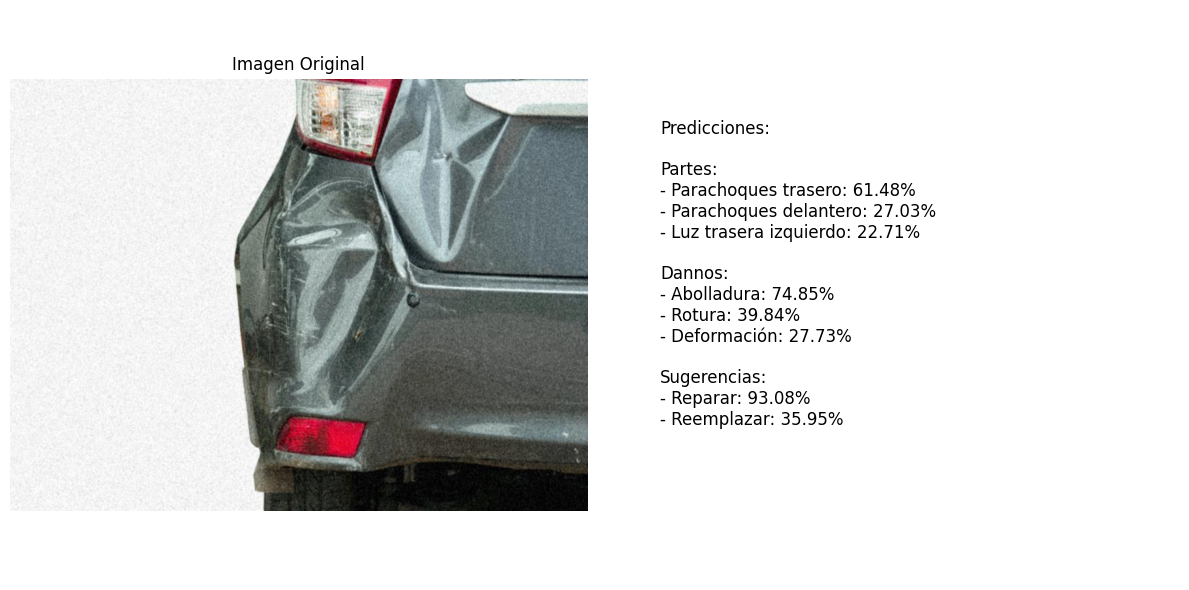

In [14]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES CON VISUALIZACIÓN
# =============================================
def predict_and_show(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """
    Realiza predicciones para una nueva imagen y la muestra junto con los resultados
    
    Args:
        image_path: Ruta a la imagen a predecir
        model: Modelo cargado para hacer predicciones
        mlb_partes: MultiLabelBinarizer para partes
        mlb_dannos: MultiLabelBinarizer para daños
        mlb_sugerencias: MultiLabelBinarizer para sugerencias
        img_size: Tamaño de la imagen para redimensionamiento
    """
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # 1. Mostrar la imagen original
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis('off')
    
    # 2. Preprocesar la imagen para el modelo
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, img_size)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 3. Hacer predicción
    predictions = model.predict(img_array)
    
    # 4. Procesar resultados
    def get_top_predictions(classes, probs, label_dict, top_n=3):
        """Obtiene las top N predicciones con sus nombres y probabilidades"""
        top_items = sorted(zip(classes, probs[0]), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]
    
    resultados = {
        'partes': get_top_predictions(mlb_partes.classes_, predictions[0], label_to_cls_piezas),
        'dannos': get_top_predictions(mlb_dannos.classes_, predictions[1], label_to_cls_danos),
        'sugerencias': get_top_predictions(mlb_sugerencias.classes_, predictions[2], label_to_cls_sugerencias)
    }
    
    # 5. Mostrar resultados
    plt.subplot(1, 2, 2)
    text_content = "Predicciones:\n\n"
    
    for category, items in resultados.items():
        text_content += f"{category.capitalize()}:\n"
        if not items:
            text_content += "- No se identificaron predicciones significativas\n"
        else:
            for name, prob in items:
                text_content += f"- {name}: {prob:.2%}\n"
        text_content += "\n"
    
    plt.text(0.1, 0.5, text_content, fontsize=12, va='center')
    plt.axis('off')
    plt.tight_layout()
    
    # Mostrar todo
    plt.show()
    
    return resultados

# Visualización y predicción ejemplo
resultados = predict_and_show(
    image_path=image_path,
    model=model,
    mlb_partes=mlb_partes,
    mlb_dannos=mlb_dannos,
    mlb_sugerencias=mlb_sugerencias
)

In [15]:
# Guardar resultados
def save_evaluation_results(results, filename='evaluation_results_fine_tuning.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning.json


In [16]:
# =============================================
# GUARDAR RESULTADOS
# =============================================
def save_evaluation_results(results, filename='evaluation_results_fine_tuning_v2.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning_v2.json


---
cargar el modelo ya entrenado

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import applications
import os

# Diccionarios de mapeo (debe adaptarse si se usan otros)
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

def load_model(model_path):
    """
    Carga un modelo guardado en formato .keras o .h5 sin necesidad de reentrenar.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

def preprocess_image(image_path, img_size=(224, 224)):
    """
    Carga y preprocesa una imagen para la predicción.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image_path, model, mlb_partes, mlb_danos, mlb_sugerencias):
    """
    Realiza predicción usando el modelo cargado para una imagen dada.
    """
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    def get_top_predictions(classes, probs, label_dict, top_n=3):
        top_items = sorted(zip(classes, probs), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]

    partes_pred = get_top_predictions(mlb_partes.classes_, partes_probs, label_to_cls_piezas)
    dannos_pred = get_top_predictions(mlb_danos.classes_, dannos_probs, label_to_cls_danos)
    sugerencias_pred = get_top_predictions(mlb_sugerencias.classes_, sugerencias_probs, label_to_cls_sugerencias)

    return {
        'partes': partes_pred,
        'dannos': dannos_pred,
        'sugerencias': sugerencias_pred
    }

In [26]:
# Ejemplo de uso (adaptar mlb_* según su entorno)
if __name__ == "__main__":
    import pickle

    # Cargar modelo
    model_path = "final_model_fine_tuned_v2.keras"  # Cambiar si se usa otro archivo
    model = load_model(model_path)

    # Cargar MultiLabelBinarizer guardados (adaptar rutas)
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

Modelo cargado desde final_model_fine_tuned_v2.keras


In [27]:
# Ruta imagen para predecir
image_path = "../data/predecir/golpe_01.jpg"

In [28]:
# Realizar predicción
prediction = predict(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)

print("Predicciones:")
for category, preds in prediction.items():
    print(f"\n{category.capitalize()}:")
    for name, prob in preds:
        print(f"- {name}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
Predicciones:

Partes:
- Rueda: 34.73%
- Guardabarros delantero izquierdo: 27.82%
- Parachoques delantero: 24.46%

Dannos:
- Abolladura: 54.11%
- Rotura: 42.21%
- Desprendimiento: 17.35%

Sugerencias:
- Reparar: 73.02%
- Reemplazar: 43.34%


---